In [24]:
# 手写causal LMde selfattention+ffn

import torch
import math
from torch import nn

class SimpleDecoderLayer(nn.Module):
    def __init__(self, hidden_dim, head_num, attention_dropout_rate = 0.1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.head_num = head_num
        self.head_dim = hidden_dim // head_num

        # mha
        self.q_proj = nn.Linear(hidden_dim,hidden_dim)
        self.k_proj = nn.Linear(hidden_dim,hidden_dim)
        self.v_proj = nn.Linear(hidden_dim,hidden_dim)
        self.o_proj = nn.Linear(hidden_dim,hidden_dim)
        self.drop_att = nn.Dropout(attention_dropout_rate)
        self.att_ln = nn.LayerNorm(hidden_dim, eps = 0.0000001) # 防止除以0

        # ffn
        self.up_proj = nn.Linear(hidden_dim,4*hidden_dim) # swishGLU  应该变成8/3
        self.down_proj = nn.Linear(4*hidden_dim, hidden_dim)
        self.act_fn = nn.GELU()
        self.drop_ffn = nn.Dropout(0.1)
        self.ffn_ln = nn.LayerNorm(hidden_dim, eps = 0.0000001)

    def attention_layer(self,Q,K,V,attention_mask = None):
        K = K.transpose(-1,-2)
        attention_weight  = (Q@K)/math.sqrt(self.hidden_dim)
        if attention_mask is not None:
            attention_mask = attention_mask.tril()
            attention_weight = attention_weight.masked_fill(
                attention_mask == 0, -torch.inf
            )
        else:
            attention_mask = torch.ones_like(attention_weight).tril()
            # 只要左下角的三角的数字  因为decoder是自回归的 一个个知道内容的
            attention_weight = attention_weight.masked_fill(
                attention_mask == 0, -torch.inf
            )
        attention_weight = torch.softmax(attention_weight, -1)
        attention_weight = self.drop_att(attention_weight) # dropout变成0 所以是在softmax以后  否则再dropout就会变成1
        mid_output = attention_weight @ V
        output = mid_output.transpose(1,2).reshape(self.batch, self.seq, -1)
        output = self.o_proj(output)
        return output
        

    def mha(self, X, mask=None):
        self.batch, self.seq, _ = X.shape # 不用self的话batch seq不能用在attention_layer函数中
        Q = self.q_proj(X).reshape(self.batch,self.seq, self.head_num, self.head_dim).permute(0,2,1,3)
        K = self.k_proj(X).reshape(self.batch,self.seq, self.head_num, self.head_dim).permute(0,2,1,3)
        V = self.v_proj(X).reshape(self.batch,self.seq, self.head_num, self.head_dim).permute(0,2,1,3)

        output = self.attention_layer(Q,K,V,mask) # 注意 引用自己的函数要加一个self

        return self.att_ln(X+output)

    def ffn(self, X):
        up = self.up_proj(X)
        up = self.act_fn(up)
        down = self.down_proj(up)
        down = self.drop_ffn(down)
        # post layernorm
        return self.ffn_ln(X+down)

    def forward(self, X, attention_mask = None):
        att_output = self.mha(X, attention_mask)
        ffn_output = self.ffn(att_output)
        return ffn_output

In [31]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_list = nn.ModuleList(
            [
                SimpleDecoderLayer(64, 8) for i in range(5)
            ]
        )
        self.emb = nn.Embedding(12, 64)
        self.out = nn.Linear(64,12)

    def forward(self, X ,mask=None):
        X = self.emb(X)
        for i,l in enumerate(self.layer_list):
            X = l(X, mask)
        print(X.shape)
        output = self.out(X)
        return torch.softmax(output, dim=-1)


X = torch.randint(0,12,(3,4))
# https://zhuanlan.zhihu.com/p/683843585  nn.linear 和nn.embedding的区别
# （3,4）的矩阵（要求这个矩阵每个数都是整数）的每一个int在nn.embedding（12,64）的矩阵中选取一行
# （20,64）都可以 只不过后八行不会被取到
# 所以就变成了3 4 64

net = Decoder()
mask = torch.tensor(
    [
    [1,1,1,1],
    [1,1,1,0],
    [1,1,0,0],
    ]
).unsqueeze(1).unsqueeze(2).repeat(1,8,4,1) # mask一开始的大小应该是batch seq
# 变化后是batch headnum seq seq
net(X, mask)

torch.Size([3, 4, 64])


tensor([[[0.0231, 0.0421, 0.2250, 0.1877, 0.0348, 0.0741, 0.0963, 0.0655,
          0.0587, 0.0294, 0.1098, 0.0536],
         [0.0589, 0.0805, 0.1756, 0.0443, 0.0827, 0.1540, 0.0670, 0.1127,
          0.0625, 0.1247, 0.0263, 0.0108],
         [0.0388, 0.1108, 0.0716, 0.0848, 0.0639, 0.0708, 0.0285, 0.1070,
          0.0567, 0.0676, 0.1780, 0.1214],
         [0.0338, 0.0624, 0.1642, 0.0883, 0.0440, 0.0776, 0.0436, 0.0660,
          0.0967, 0.1539, 0.0968, 0.0728]],

        [[0.1214, 0.0419, 0.0665, 0.0461, 0.1282, 0.1149, 0.0488, 0.1000,
          0.0901, 0.0399, 0.1305, 0.0718],
         [0.0593, 0.1898, 0.0833, 0.0312, 0.0538, 0.0812, 0.1495, 0.1211,
          0.0818, 0.0295, 0.0851, 0.0343],
         [0.0442, 0.0870, 0.1739, 0.0812, 0.0489, 0.0565, 0.0738, 0.0982,
          0.0759, 0.0877, 0.1081, 0.0645],
         [0.0519, 0.0580, 0.1446, 0.0709, 0.0496, 0.0671, 0.0671, 0.1002,
          0.0748, 0.0910, 0.1307, 0.0940]],

        [[0.1667, 0.0437, 0.0694, 0.0423, 0.0836, 0.1063, 0.

In [13]:
mask = torch.tensor(
    [
    [1,1,1,1],
    [1,1,1,0],
    [1,1,0,0],
    ]
).unsqueeze(1).unsqueeze(2).repeat(1,8,4,1) # mask一开始的大小应该是batch seq

In [15]:
mask1 = torch.tensor(
    [
    [1,1,1,1],
    [1,1,1,0],
    [1,1,0,0],
    ]
).unsqueeze(1).unsqueeze(2).expand(3,8,4,4)

In [18]:
(mask1 != mask).sum()  # 完全一致

tensor(0)

# 参数量的计算

这里计算的用casual LM的参数量（是decoder 而且没有其中的masked multihead）不能知道后续的token

智谱的chatGLM是prefix LM 也就是图3，是能够知道后续的token的
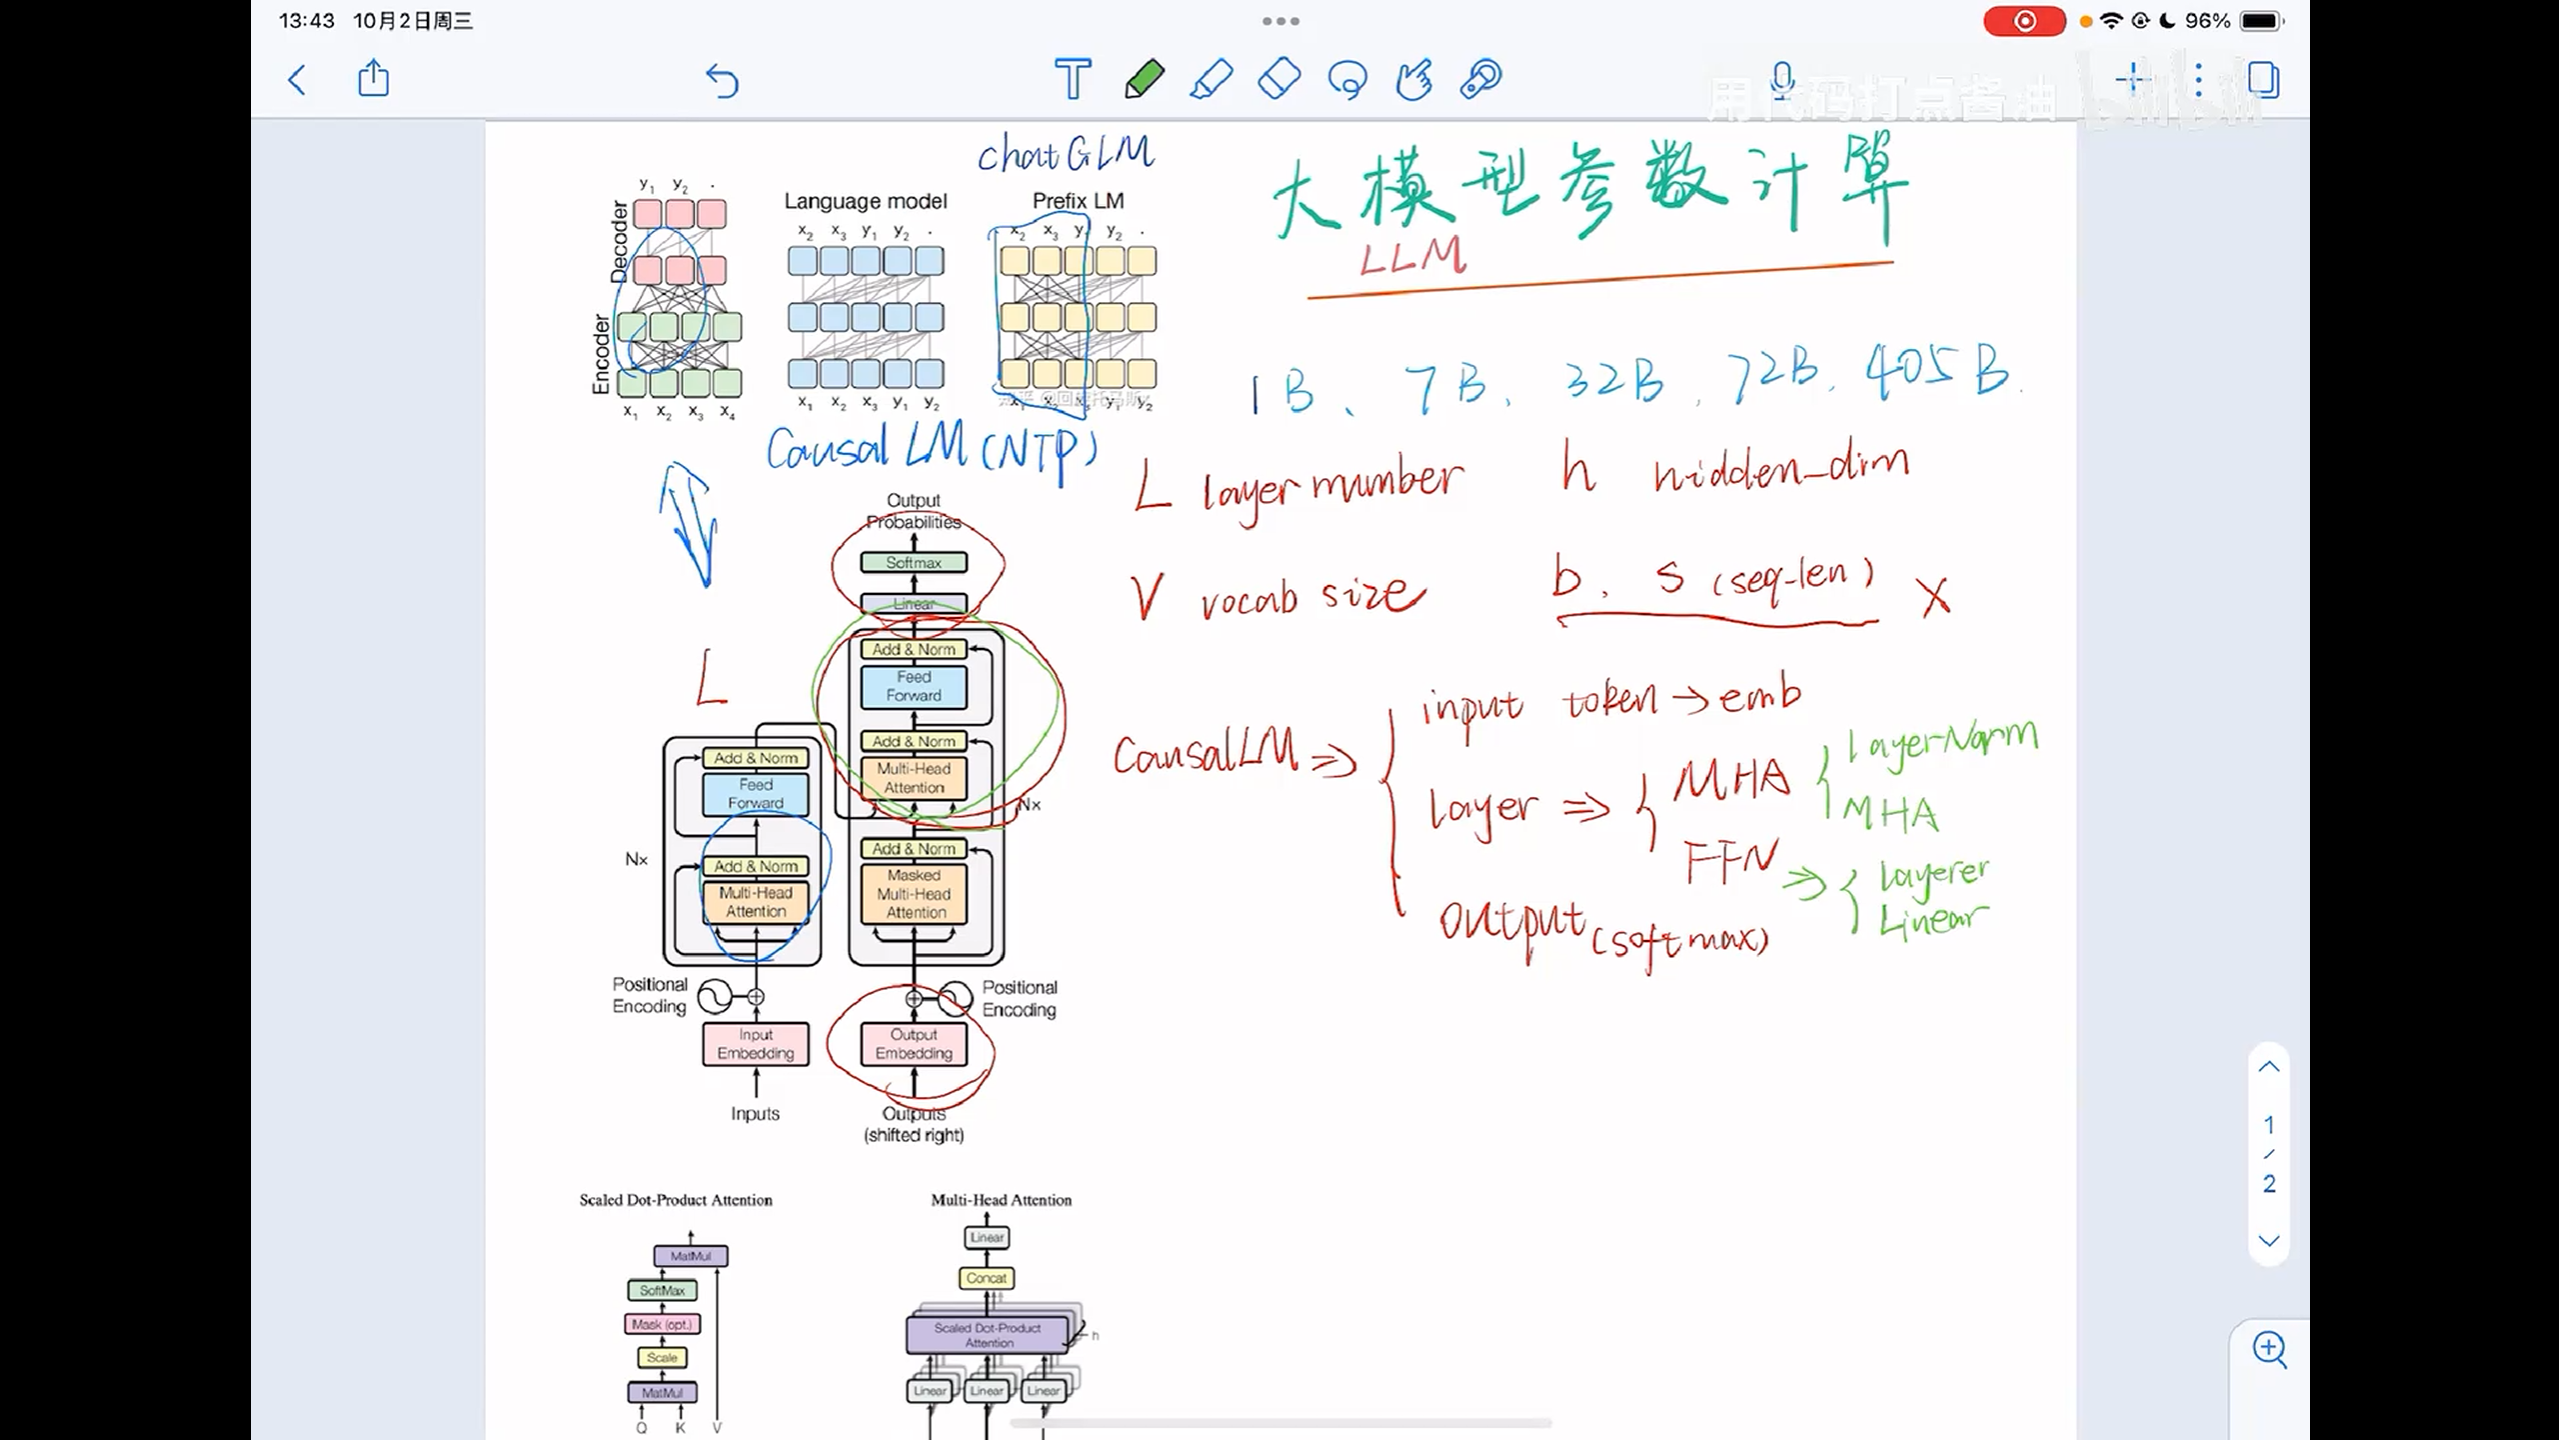


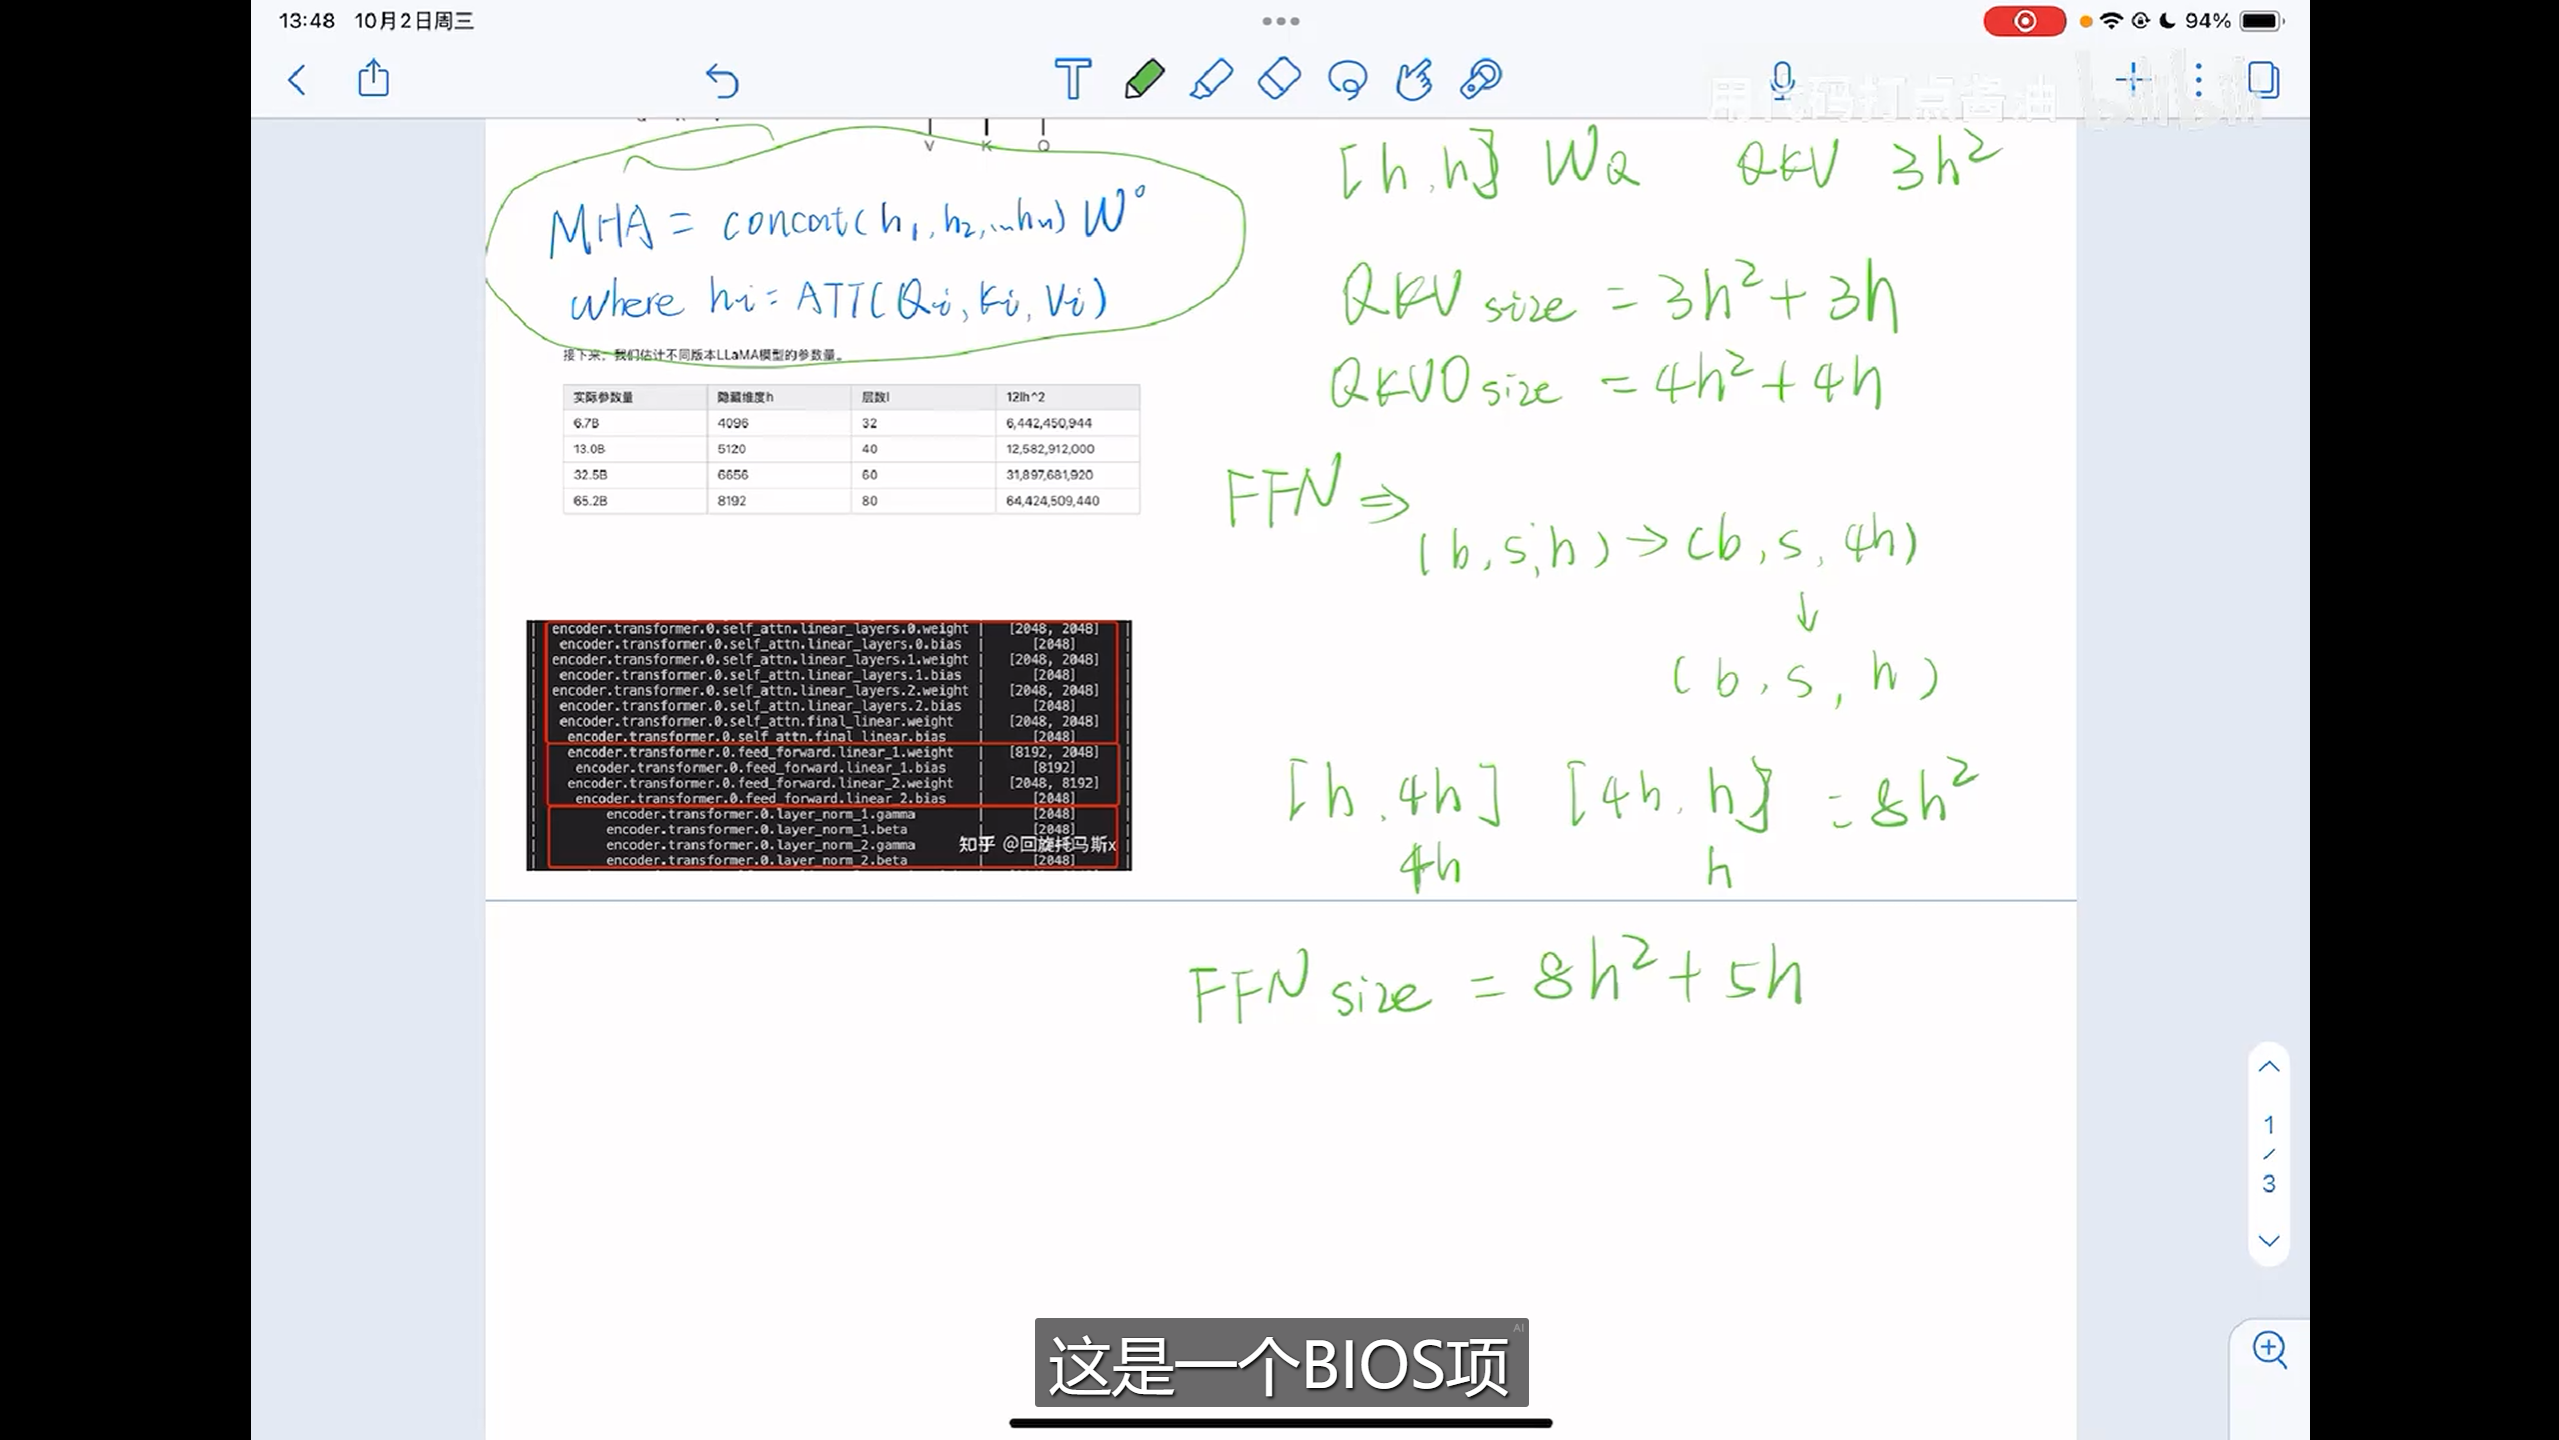
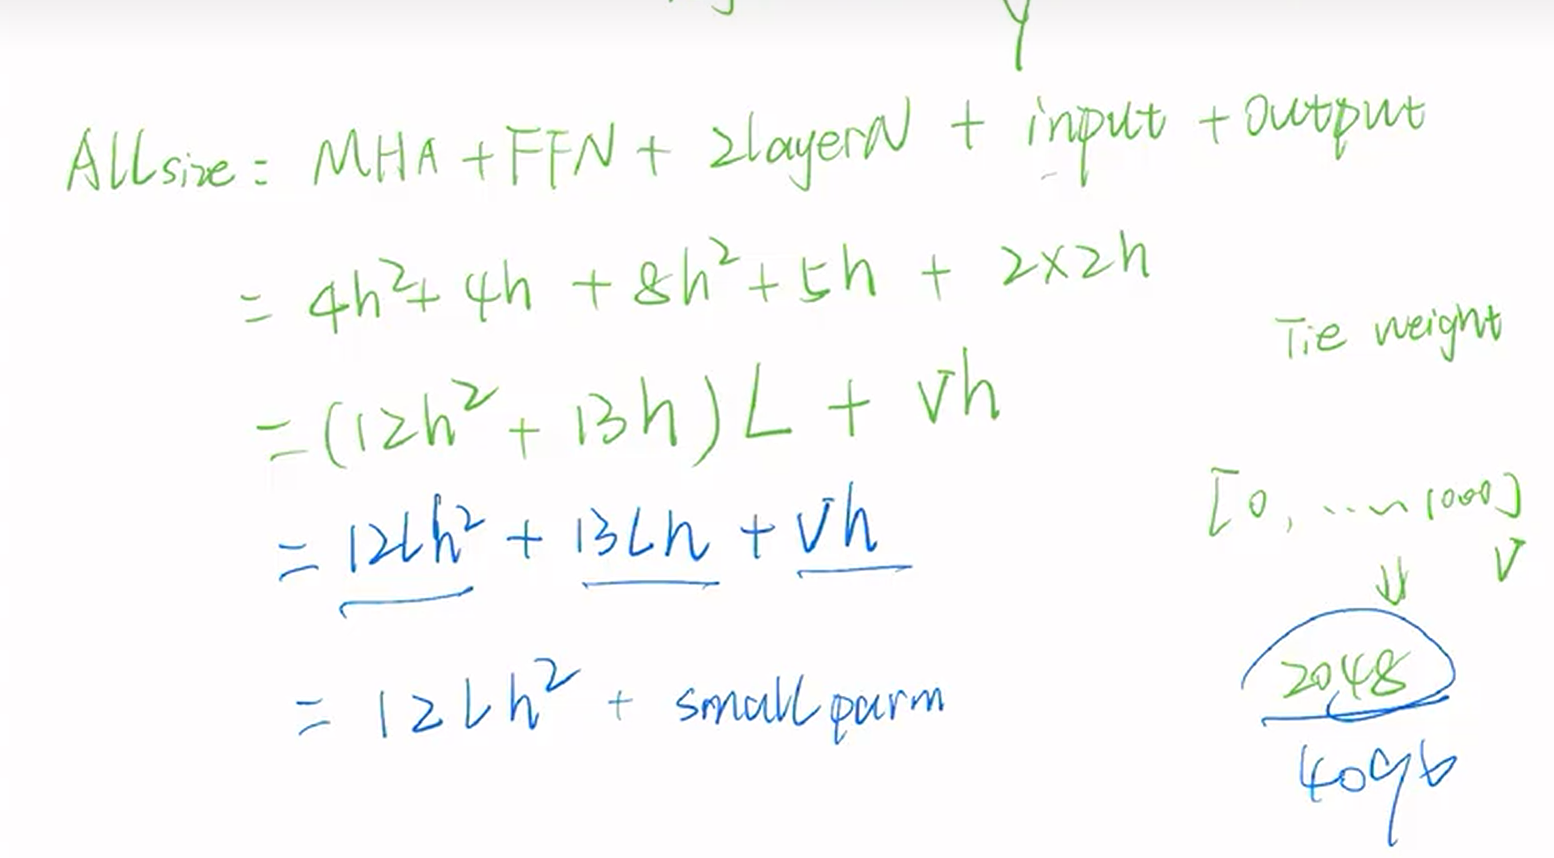